In [ ]:
!/opt/conda/bin/python -m pip install --upgrade pip
!conda install matplotlib seaborn
!conda install tensorflow
!pip install ta

In [316]:
from packaging import version

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import glob
from pprint import pprint
from tensorflow.compat.v1.train import summary_iterator
import ta
sns.set_theme(style="darkgrid")

In [355]:
import glob
import re


def extract_filelist(keywords):
    '''
    input: list of keywords
    output: list of tensorboard event log file
    '''
    re_format = '^/tblog/'+'.*'.join(keywords+['events\.out'])
    logpaths = glob.glob('/tblog/**', recursive=True)
    return [i for i in logpaths if re.match(re_format, i)]

def extract_summary_word(logfile_path):
    res = re.search('[0-9]{2}\.[0-9]{2}\.[0-9]{2}/.*/events', logfile_path)
    if res is None:
        raise TypeError
    tmp = res.group()
    tmp = re.sub('[0-9]{2}\.[0-9]{2}\.[0-9]{2}/', '', tmp)
    tmp = re.sub('/events', '', tmp)
    return tmp

def read_data(logfile_path):
    '''
    input:  string, tblog file path
    output: Pandas DataFrame witch only have step and single data series
    '''
    keyword = extract_summary_word(logfile_path)
    tmp = np.array([(e.step, list(e.summary.value)[0].simple_value) for e in summary_iterator(logfile_path) if e.summary.value]).T
    step, data = tmp[0].astype(int), tmp[1]
    return pd.DataFrame({'step':step, keyword:data})

def read_datas(logfile_paths):
    '''
    input:  list of logfile paths, 
        [tbfile_path1, tbfile_path2, tbfile_path3], 
        considering if there are several keyword in same experiments
    output: Oandas DataFrame contains several data series
    '''
    log_dataframe = [read_data(path) for path in logfile_paths]
    assert all([len(i)==len(log_dataframe[0]) for i in log_dataframe]), 'length of dataframes are different'
    memo = {}
    for df in log_dataframe:
        for col in df.columns:
            memo[col] = df[col]
    return pd.DataFrame(memo)
    
    
def calculate_mean_among(dataframes):
    '''
    input: list of DataFrame
        Considering they all have column 'step'
    output: DataFrame, contained average of all columes
    '''
    l = len(dataframes)
    step = pd.DataFrame(dataframes[0]['step'])
    res = dataframes[0].drop('step', axis=1)
    for i in dataframes[1:]:
        res += i.drop('step', axis=1)
    res = res/l
    return pd.concat([step, res], axis=1)
    
    
def plot_origin_sma(df, tag, window=200, rgbcolor=(0,0,1),alpha=0.1, no_label=False):
    '''
    inputs:
        df:  DataFrame you wants to plot
        tag:  column name, string
        rgbcolor: RGB color code in (float, float, float)  value sould be 0~1
    output:  None
    This function must be used between final plot
    '''
    plt.plot(df.step, df[tag], color=(*rgbcolor,alpha), label=None if no_label else tag)
    plt.plot(df.step, ta.trend.sma_indicator(df[tag], window), 
             color=(*rgbcolor,1), label=None if no_label else '{}:SMA({})'.format(tag, window))
    
def quick_plot()

In [115]:
logpaths = glob.glob('/tblog/**', recursive=True)
paths = [i for i in logpaths if re.match('/tblog/a2c_regular.*final_rewards_max.*events', i)]
pprint(paths)

['/tblog/a2c_regular_2_0bbf458fbb9a2204ab63eb3af4640a11/20210107-23.04.46/final_rewards_max/events.out.tfevents.1610028287.bd4542dbe1dd.4342.1',
 '/tblog/a2c_regular_3_4c08cef566b452e39efa8078e94b1f9f/20210107-23.04.57/final_rewards_max/events.out.tfevents.1610028297.bd4542dbe1dd.4417.1',
 '/tblog/a2c_regular_4_7c8fecec396a51321a9ca5549c9c606e/20210107-23.05.09/final_rewards_max/events.out.tfevents.1610028310.bd4542dbe1dd.4492.1',
 '/tblog/a2c_regular_1_89076312b9d0562a4bbf7ced3e6c3cca/20210107-23.04.35/final_rewards_max/events.out.tfevents.1610028275.bd4542dbe1dd.4267.1',
 '/tblog/a2c_regular_5_437b9e0013e7dd3674068017901ee066/20210107-23.05.19/final_rewards_max/events.out.tfevents.1610028319.bd4542dbe1dd.4560.1']


In [266]:
path = extract_filelist(['a2c', 'regular_1', 'final'])

In [290]:
exps = []
for i in range(1, 6):
    keywords = ['a2c_regular_{}'.format(i), 'final']
    exps.append(read_datas(extract_filelist(keywords)))

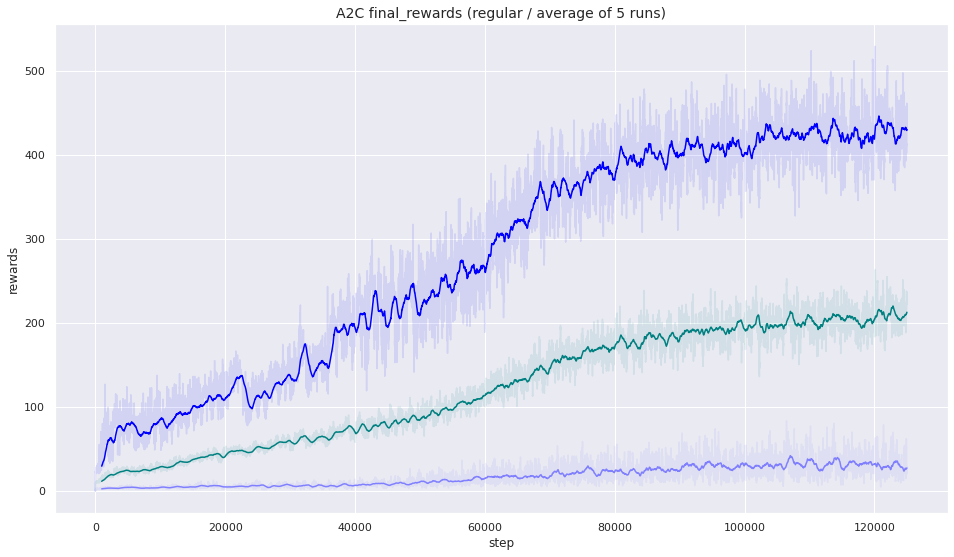

In [361]:
fig = plt.figure(figsize=(16,9))
# FigureにAxesを追加
ax = fig.add_subplot(111)
# Axesのタイトルの設定
ax.set_title("A2C final_rewards (regular / average of 5 runs)", fontsize = 14)
ax.set_xlabel("step", fontsize = 12)
ax.set_ylabel("rewards", fontsize = 12)
plot_origin_sma(averaged_log, 'final_rewards_max', rgbcolor=(0,0,1))
plot_origin_sma(averaged_log, 'final_rewards_mean', rgbcolor=(0,0.5,0.5))
plot_origin_sma(averaged_log, 'final_rewards_min', rgbcolor=(0.5,0.5,1))

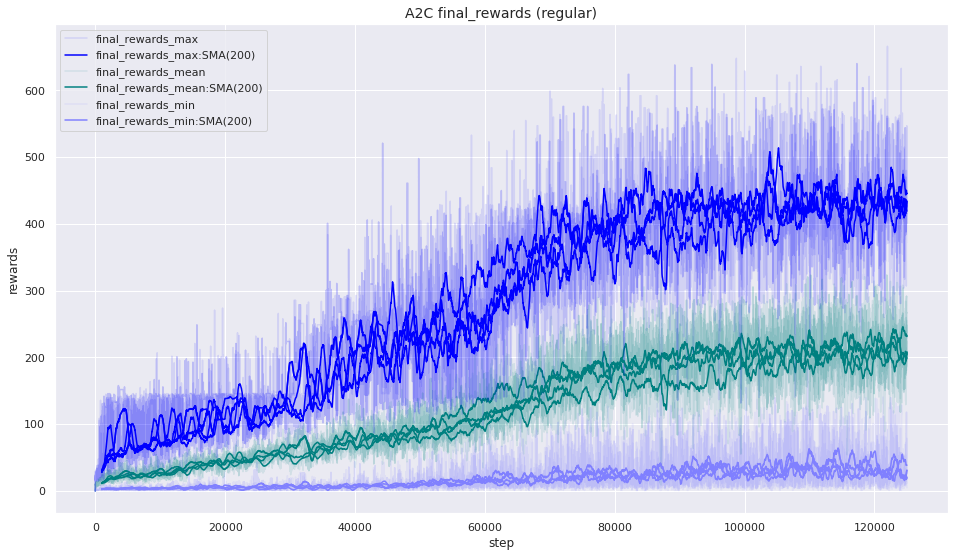

In [362]:
fig = plt.figure(figsize=(16,9))
# FigureにAxesを追加
ax = fig.add_subplot(111)
# Axesのタイトルの設定
ax.set_title("A2C final_rewards (regular)", fontsize = 14)
ax.set_xlabel("step", fontsize = 12)
ax.set_ylabel("rewards", fontsize = 12)
plot_origin_sma(exps[i], 'final_rewards_max', rgbcolor=(0,0,1))
plot_origin_sma(exps[i], 'final_rewards_mean', rgbcolor=(0,0.5,0.5))
plot_origin_sma(exps[i], 'final_rewards_min', rgbcolor=(0.5,0.5,1))
for i in range(1, len(exps)):
    plot_origin_sma(exps[i], 'final_rewards_max', rgbcolor=(0,0,1), no_label=True)
    plot_origin_sma(exps[i], 'final_rewards_mean', rgbcolor=(0,0.5,0.5), no_label=True)
    plot_origin_sma(exps[i], 'final_rewards_min', rgbcolor=(0.5,0.5,1), no_label=True)
ax.legend()